In [1]:
!pip install efficientnet

In [2]:
import os
import shutil
from PIL import Image, ImageOps  
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import plotly.graph_objects as go
import plotly.express as px
import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
pio.templates.default = 'plotly_white'
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, MaxPooling2D, Conv2D
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
import efficientnet.tfkeras as efn
from tqdm import tqdm_notebook
import tensorflow as tf
import pandas as pd

ModuleNotFoundError: No module named 'plotly'

In [25]:
# Reading through the metadata
summary = pd.read_csv('/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv')
df = pd.read_csv('/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
print(df.head())

replace_dict = {'Pnemonia':1,
                'Normal':0}
df['Label'] = df['Label'].replace(replace_dict)

train_df = df[df.Dataset_type=='TRAIN']
print(train_df.head())
test_df = df[df.Dataset_type=='TEST']
print(test_df.head())

   Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
   Unnamed: 0   X_ray_image_name  Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg      0        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg      0        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg      0        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg      0  

In [26]:
colors = ['gold', 'mediumturquoise']

fig = go.Figure(data=[go.Pie(labels=['Pneumonia', 'Normal'],
                             values=[df.Label.value_counts()[1], df.Label.value_counts()[0]])])

fig.update_traces(hoverinfo='label+value', textinfo='percent+label', textfont_size=20,
                  marker=dict(colors=colors,
                           line=dict(color='#000000',width=2)))
fig.update_layout(title_text='Distributions of classes in the data', font_size=20)
fig.show()

In [27]:
# Inside the Pneumonia idagnosed data how many are covid positive
df_pneumonia = df[df.Label==1]
df_pneumonia_covid = df_pneumonia[df_pneumonia.Label_2_Virus_category=='COVID-19']
pneumonia_covid_images = df_pneumonia_covid.X_ray_image_name.values.tolist()

In [28]:
# Defining the path to Train and Test directories
training_data_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
testing_data_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

In [29]:
# Funtions for Making nd Removing subdirectories
def create_dir():
    try:
        os.makedirs('/kaggle/working/train/Pneumonia')
        os.makedirs('/kaggle/working/train/Normal')
        os.makedirs('/kaggle/working/test/Pneumonia')
        os.makedirs('/kaggle/working/test/Normal')
    except:
        pass
def remove_dir():
    try:
        shutil.rmtree('/kaggle/working/train')
        shutil.rmtree('/kaggle/working/test')    
    except:
        pass

In [30]:
# Seperate dataframes for different labels in test and train
train_pneumonia_df = train_df[train_df.Label==1]
train_normal_df = train_df[train_df.Label==0]
test_pneumonia_df = test_df[test_df.Label==1]
test_normal_df = test_df[test_df.Label==0]

In [31]:
# Copying the files to newly created locations. You may use Flow from dataframe attribute and skip all these steps. But I prefer to use flow from directory 
remove_dir()
create_dir()

training_images_pneumonia = train_pneumonia_df.X_ray_image_name.values.tolist()
training_images_normal = train_normal_df.X_ray_image_name.values.tolist()
testing_images_pneumonia = test_pneumonia_df.X_ray_image_name.values.tolist()
testing_images_normal = test_normal_df.X_ray_image_name.values.tolist()

for image in training_images_pneumonia:
    train_image_pneumonia = os.path.join(training_data_path, str(image))
    shutil.copy(train_image_pneumonia, '/kaggle/working/train/Pneumonia')
    
for image in training_images_normal:
    train_image_normal = os.path.join(training_data_path, str(image))
    shutil.copy(train_image_normal, '/kaggle/working/train/Normal')
    
for image in testing_images_pneumonia:
    test_image_pneumonia = os.path.join(testing_data_path, str(image))
    shutil.copy(test_image_pneumonia, '/kaggle/working/test/Pneumonia')
    
for image in testing_images_normal:
    test_image_normal = os.path.join(testing_data_path, str(image))
    shutil.copy(test_image_normal, '/kaggle/working/test/Normal')

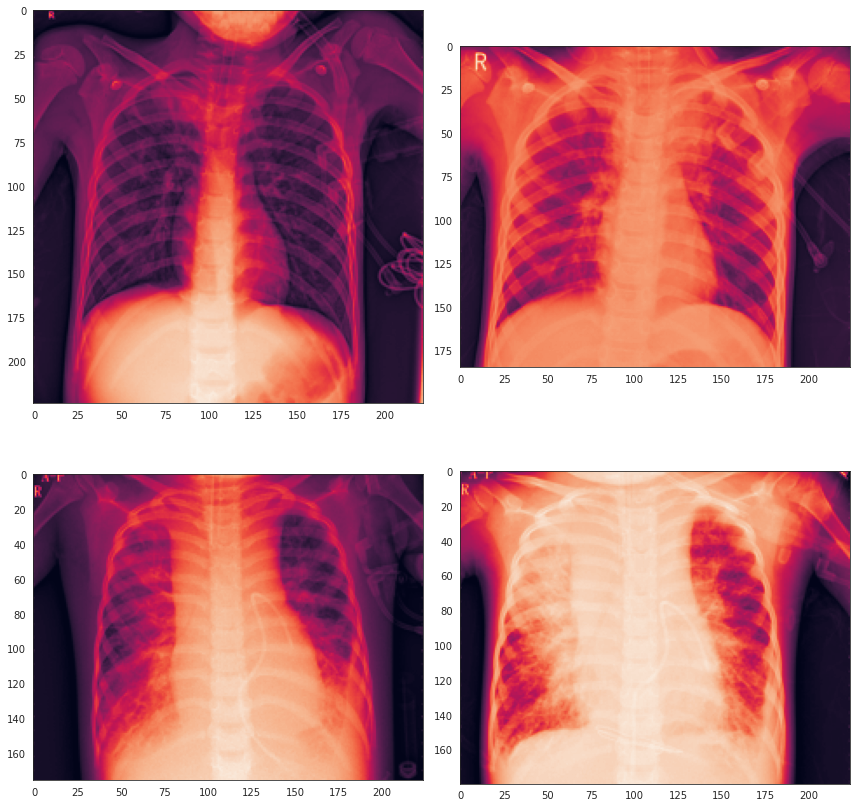

In [32]:
# VisualaiCzing the Pneumonia affected Xrays
plt.figure(figsize=(12,12))
for index, fn in enumerate(training_images_pneumonia[:4]):
    path = '/kaggle/working/train/Pneumonia/' + str(fn)
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image.thumbnail((224,224))
    plt.subplot(2,2,index+1)
    plt.imshow(image)

plt.tight_layout()

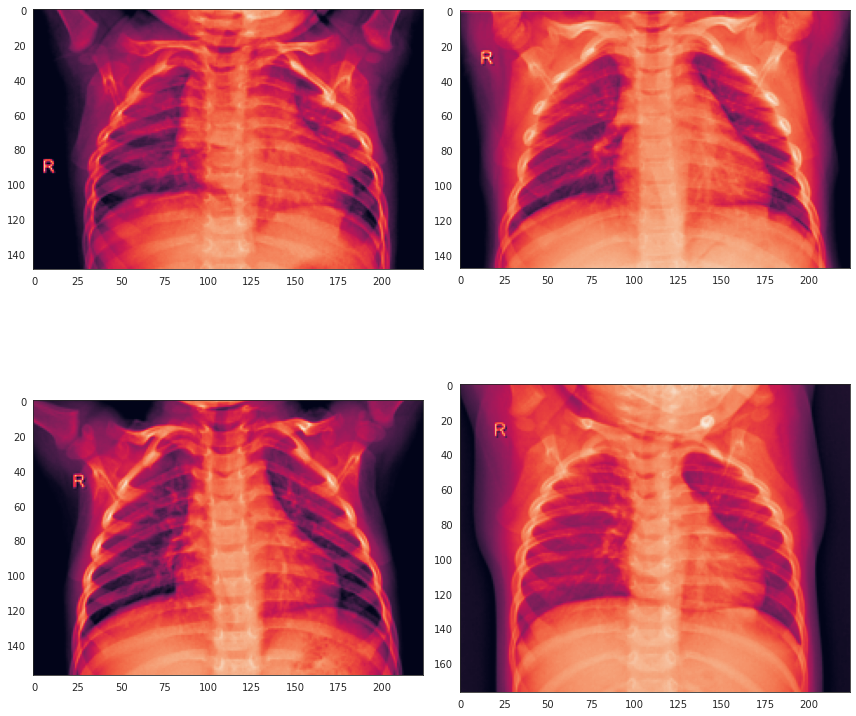

In [33]:
# VisualaiCzing the Normal  Xrays
plt.figure(figsize=(12,12))
for index, fn in enumerate(training_images_normal[:4]):
    path = '/kaggle/working/train/Normal/' + str(fn)
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image.thumbnail((224,224))
    plt.subplot(2,2,index+1)
    plt.imshow(image)

plt.tight_layout()

In [34]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
no_epochs = 15
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [43]:
#Creating an EffNet model
model_B7 = efn.EfficientNetB7(weights='imagenet', input_shape=input_shape, include_top=False)

In [44]:
# model_B7 = tf.keras.applications.NASNetLarge(
#     include_top=False,
#     weights="imagenet",
#     #input_tensor=None,
#     input_shape=input_shape,
#     pooling=None,
#     classes=1000,
# )

In [45]:
# from tensorflow.keras.layers import Input
# model_B7 = tf.keras.applications.NASNetLarge(
#     input_shape=None,
#     include_top=False,
#     weights="imagenet",
#     input_tensor=Input(shape=input_shape),
#     pooling=None,
#     classes=1000,
# )

In [ ]:
# Function to build, compile and train the model

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory('/kaggle/working/train',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('/kaggle/working/test',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

pretrained_model = model_B7
pretrained_model.trainable=True
set_trainable=False

for layer in pretrained_model.layers:
    if layer.name == 'block7c_project_conv':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False


model=Sequential()
model.add(pretrained_model)
model.add(MaxPooling2D(name="MaxPool_"))
model.add(Dropout(0.2, name="dropout_out"))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=[metrics.AUC(name='auc'), 'accuracy'])

es_callback = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = no_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//batch_size,
                    callbacks= [es_callback],
                    verbose=verbosity)

Found 5286 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
16/82 [====>.........................] - ETA: 1:24 - loss: 0.6979 - auc: 0.6981 - accuracy: 0.7344

In [ ]:
#Plotting the evaluation metrics
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['auc'],
                         line=dict(color='firebrick', width=2, dash='dash'), name='AUC'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_auc'],
                         line=dict(color='turquoise', width=2), name='validation AUC'))

fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['accuracy'],
                         line=dict(color='orange', width=2, dash='dash'), name='accuracy'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_accuracy'],
                         line=dict(color='green', width=2), name='validation accuracy'))

fig.update_layout(title_text='Plot of evaluation metrics', font_size=15, xaxis_title='Epochs')
fig.show()